In [17]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pyhepmc
import pandas as pd
from collections import Counter
from pprint import pprint
import sys
sys.path.append("../")
from utils import branching_ratios
import matplotlib

## Analyze events with polarization

In [48]:
particle_infos = {e: pd.read_csv(f"../data/test_genie_NuTau_{e}.0_GeV_particles.csv") for e in [5, 10, 20, 50, 100]}
event_infos = {e: pd.read_csv(f"../data/test_genie_NuTau_{e}.0_GeV_event_info.csv") for e in [5, 10, 20, 50, 100]}

In [49]:
particle_infos[5].head(15)

,event_num,pdg,E,px,py,pz,polx,poly,polz
0,0,1000080160,14.895082,0.000000,0.000000,0.000000,NaN,NaN,NaN
1,0,16,5.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000
2,0,15,3.903152,-0.404374,-0.448013,3.422466,-0.128915,0.116357,-0.984806
3,0,11,1.192467,0.221610,-0.264795,1.141380,NaN,NaN,NaN
4,0,-12,2.320251,-0.895265,-0.402346,2.102423,NaN,NaN,NaN
5,0,16,0.390469,0.269274,0.219157,0.178684,NaN,NaN,NaN
6,1,1000080160,14.895082,0.000000,0.000000,0.000000,NaN,NaN,NaN
7,1,16,5.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000
8,1,15,4.783084,0.080610,-0.132914,4.438090,-0.029930,-0.018152,-0.999387
9,1,-211,2.350075,-0.774235,0.276101,2.197203,NaN,NaN,NaN


In [51]:
def sanity_checks(particle_info: pd.DataFrame):
    # Check if there are any events where two taus are produced
    # There should not be any
    assert not (particle_info[np.abs(particle_info['pdg']) == 15].groupby("event_num").count() > 1).any().any()

    taus = particle_info[np.abs(particle_info["pdg"]) == 15]
    # assert (taus["event_num"] == np.arange(len(taus))).all()
    print("Number of events:", len(taus))
    # Print the 4-momentum conservation between tau and its decay products
    print(
        np.unique(
            np.isclose(
                particle_info
                    .drop(["pdg", "polx", "poly", "polz"], axis=1)
                    .groupby("event_num")
                    .nth[3:]
                    .groupby("event_num")
                    .sum(), 
                taus
                    .set_index("event_num")
                    .drop(["pdg", "polx", "poly", "polz"], axis=1)
                , rtol=0.01)
            .sum(axis=1)
            , return_counts=True
        )
    )

    # Print the branching ratios
    br = branching_ratios(particle_info.groupby("event_num").nth[3:])
    pprint(br, sort_dicts=False)
    # Geant4 only implements 6 decay modes for the tau
    assert len(br) == 6, br

    branching_ratios(particle_info.groupby("event_num").nth[3:])

    # Check that for every event with a tau there is a tau neutrino, and vice versa for anti-tau
    # TODO speed up this code by removing the for-loop
    assert particle_info.groupby("event_num")["pdg"].agg(lambda values, index: np.all(values[np.abs(values) == 15] * values[np.abs(values) == 16] > 0), engine="numba").all()

    # Check that the nucleus is either 1000080160 or 2212
    nucleus = particle_info.groupby("event_num").first().iloc[:, 0]
    assert (nucleus == 1000080160).sum() + (nucleus == 2212).sum() == len(nucleus), nucleus

    # Check that the polarization vectors for the tau are either 0 or 1 in magnitude
    tau_pol_mag = taus[["polx", "poly", "polz"]].pow(2).sum(axis=1)
    assert np.isclose(tau_pol_mag[tau_pol_mag != 0], 1).all()
    assert not tau_pol_mag.isnull().any()
    print("Number of taus with 0 polarization:", (tau_pol_mag == 0).sum())
    print("number of events with 0 polx, poly, polz:", (particle_info.query("pdg == 15")[["polx", "poly", "polz"]] == 0).all(axis=1).sum())
    print("Number of taus with NaN polarization:", (tau_pol_mag.isnull()).sum())
    print("Number of taus with 1 polarization:", np.isclose(tau_pol_mag, 1).sum())

    incoming_nutau = particle_info.groupby("event_num").nth(1)
    # Check that the incoming neutrinos are tau neutrinos
    assert set(incoming_nutau["pdg"].unique().tolist()) <= {16, -16}
    # Check that the polarization vectors for all incoming neutrinos are 0
    assert (particle_info.groupby("event_num").nth(1)[["polx", "poly", "polz"]] == 0).all().all()
    # Check that all incoming neutrinos have the same 4-momenta
    assert (incoming_nutau[["E", "px", "py", "pz"]] == incoming_nutau.iloc[0][["E", "px", "py", "pz"]]).all(axis=0).all()
    
    # Check that the polarization vectors for all other particles are 0
    assert particle_info.drop(incoming_nutau.index, axis=0).query("pdg != 15")[["polx", "poly", "polz"]].isnull().all().all(), particle_info.drop(incoming_nutau.index, axis=0).query("(pdg != 15) and (polx.notnull() or poly.notnull() or polz.notnull())")

for e, particle_info in particle_infos.items():
    print(f"Energy: {e} GeV")
    sanity_checks(particle_info)
    print()

Energy: 5 GeV
Number of events: 17881
(array([2, 3, 4]), array([   57,  1352, 16472]))
{(-211, 16, 111): 0.2819752810245512,
 (-12, 11, 16): 0.19646552206252446,
 (-14, 13, 16): 0.19098484424808457,
 (-211, 16): 0.12762149767910072,
 (-211, -211, 16, 211): 0.10368547620379173,
 (-211, 16, 111, 111): 0.09926737878194732}
Number of taus with 0 polarization: 0
number of events with 0 polx, poly, polz: 0
Number of taus with NaN polarization: 0
Number of taus with 1 polarization: 17881

Energy: 10 GeV
Number of events: 42493
(array([2, 3, 4]), array([   66,  2509, 39918]))
{(-211, 16, 111): 0.28416445061539547,
 (-12, 11, 16): 0.1957028216412115,
 (-14, 13, 16): 0.18989009954580754,
 (-211, 16): 0.12303202880474431,
 (-211, -211, 16, 211): 0.1052408632009978,
 (-211, 16, 111, 111): 0.10196973619184337}
Number of taus with 0 polarization: 0
number of events with 0 polx, poly, polz: 0
Number of taus with NaN polarization: 0
Number of taus with 1 polarization: 42493

Energy: 20 GeV
Number of e

In [54]:
for e, event_info in event_infos.items():
    # Cross section should be > 0
    assert event_info["xsec"].all() > 0
    # All events should be charge-current
    assert event_info["cc"].all()

    # Number of events for each interaction type
    print("E =", e, "GeV")
    print(event_info.sum(axis=0).drop(["event_num", "xsec", "cc"]))
    # All events should either be DIS, quasi-elastic or resonance scattering
    # assert (event_info[["dis", "qel", "res"]].sum(axis=1) == 1).all(), event_info.query("(dis == 0) and (qel == 0) and (res == 0)")
    # print(event_info.query("(dis == 0) and (qel == 0) and (res == 0)").sum(axis=0).drop(["event_num", "xsec", "cc"]))

E = 5 GeV
dis        0.0
qel     9682.0
res     8199.0
nuel       0.0
coh        0.0
dfr        0.0
imd        0.0
dtype: float64
E = 10 GeV
dis     21386.0
qel      7006.0
res     14101.0
nuel        0.0
coh         0.0
dfr         0.0
imd         0.0
dtype: float64
E = 20 GeV
dis     45583.0
qel      3396.0
res      7303.0
nuel        0.0
coh         0.0
dfr         0.0
imd         0.0
dtype: float64
E = 50 GeV
dis     62488.0
qel      1166.0
res      2633.0
nuel        0.0
coh        76.0
dfr         0.0
imd         0.0
dtype: float64
E = 100 GeV
dis     68380.0
qel       474.0
res      1184.0
nuel        0.0
coh        55.0
dfr         0.0
imd         0.0
dtype: float64


4-momentum seems to be mostly conserved down to the 1% level.

### Analyze polarization of events

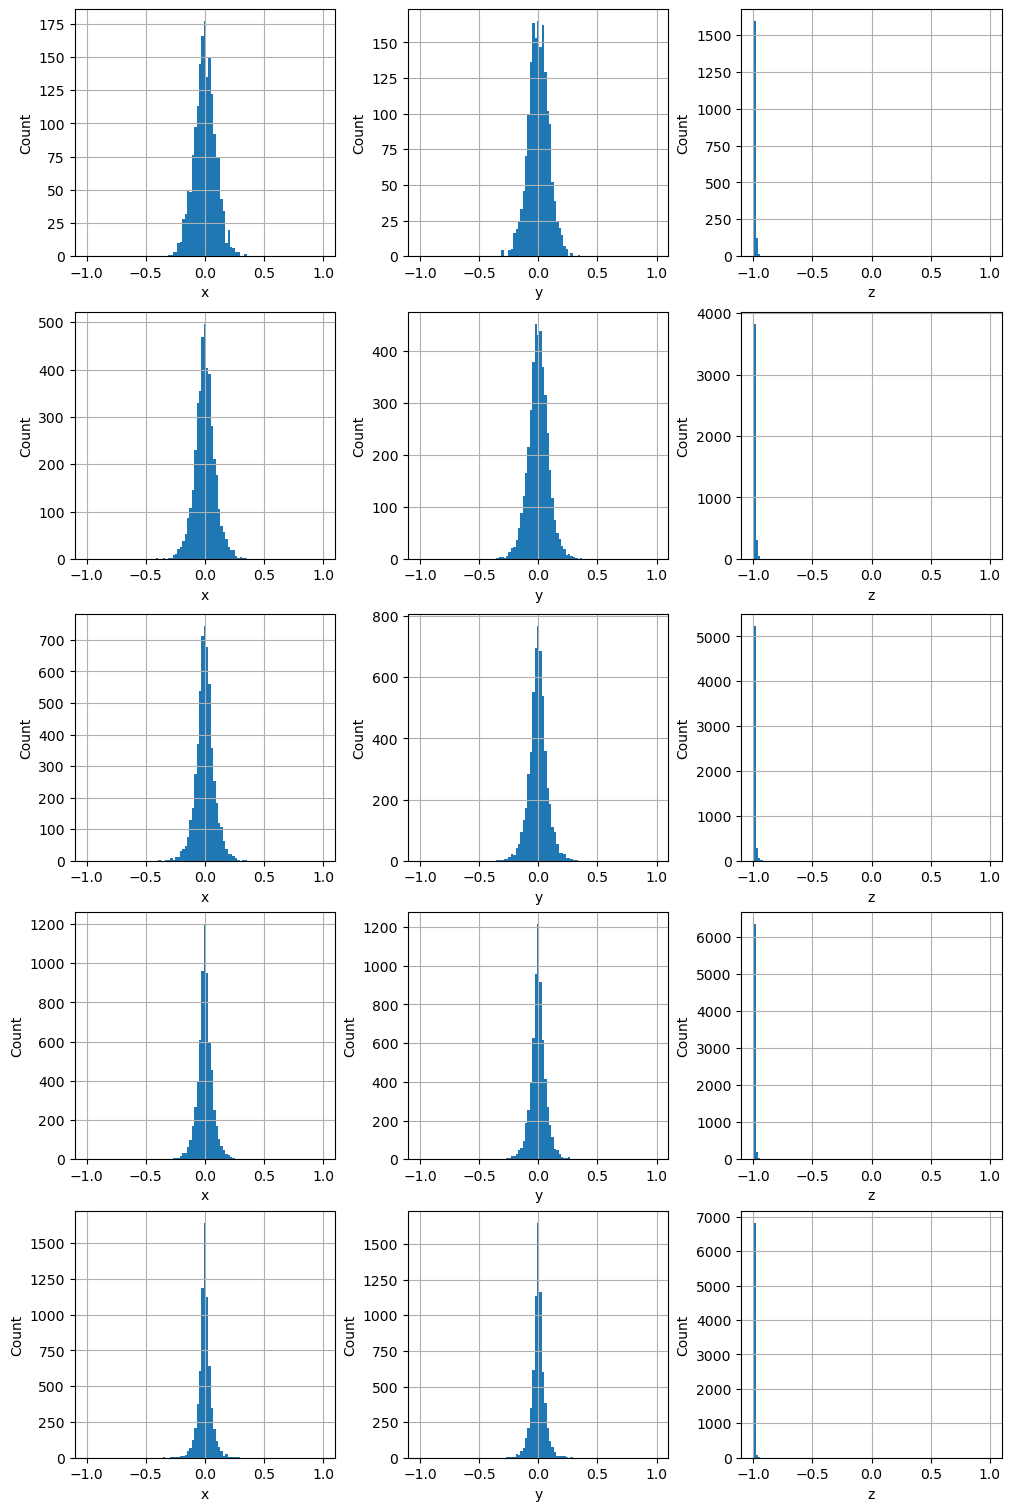

In [11]:
## Polarization
# Investigate how may of the tau leptons are polarized and how much
fig, axs = plt.subplots(ncols=3, nrows=len(particle_infos), figsize=(10,3*len(particle_infos)), layout="constrained")

for (e, p), ax_row in zip(particle_infos.items(), axs):
    taus = p.query("pdg == 15")
    for ax, axis in zip(ax_row, ["x", "y", "z"]):
        ax.hist(taus[f"pol{axis}"], bins=np.linspace(-1, 1, 100))
        ax.set(xlabel=axis, ylabel="Count")
        ax.grid(True)

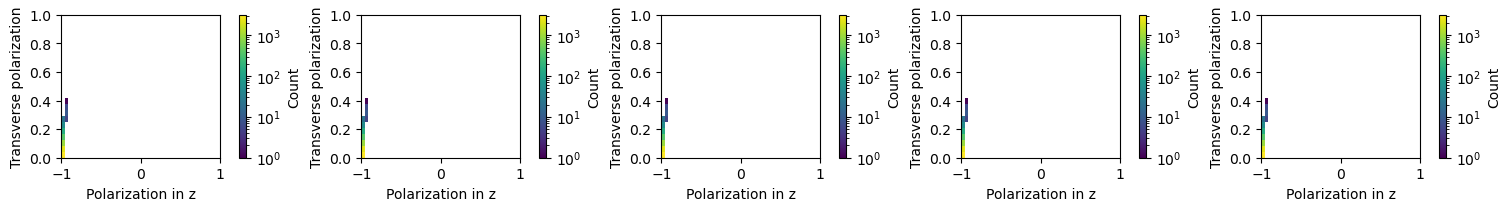

In [16]:
fig, axs = plt.subplots(ncols=len(particle_infos), figsize=(3*len(particle_infos), 2), layout="constrained")

for (e, p), ax in zip(particle_infos.items(), axs):
    # Plot a 2D histogram of the polarization, with pz as one component and the transverse polarization as the other
    *_, im = ax.hist2d(taus["polz"], np.sqrt(taus["polx"]**2 + taus["poly"]**2), bins=(np.linspace(-1, 1, 50), np.linspace(0, 1, 25)), norm=matplotlib.colors.LogNorm())
    fig.colorbar(im, ax=ax, label="Count")
    ax.set(xlabel="Polarization in z", ylabel="Transverse polarization")

In [77]:
# For the 5 GeV events, pick out the tau leptons that have an angle relative to the z axis of > 90 degrees
large_angle_event_nums = particle_infos[5].query("pdg == 15 and (px**2 + py**2)**0.5 / pz > 0.2")["event_num"]
large_angle_events = particle_infos[5][particle_infos[5]["event_num"].isin(large_angle_event_nums)]
large_angle_events

,event_num,pdg,E,px,py,pz,polx,poly,polz
30,5,1000080160,14.895082,0.000000,0.000000,0.000000,NaN,NaN,NaN
31,5,16,5.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000
32,5,15,4.280510,-0.197342,0.773493,3.811619,0.198621,0.050674,-0.978765
33,5,111,1.207851,0.265603,-0.421838,1.091876,NaN,NaN,NaN
34,5,111,0.729694,-0.168661,0.283098,0.636902,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
108519,17862,16,5.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000
108520,17862,15,3.937676,-0.715140,0.033063,3.440303,0.009409,0.203511,-0.979027
108521,17862,111,1.023486,0.138900,-0.457141,0.895005,NaN,NaN,NaN
108522,17862,16,0.218811,-0.217166,-0.017407,-0.020347,NaN,NaN,NaN


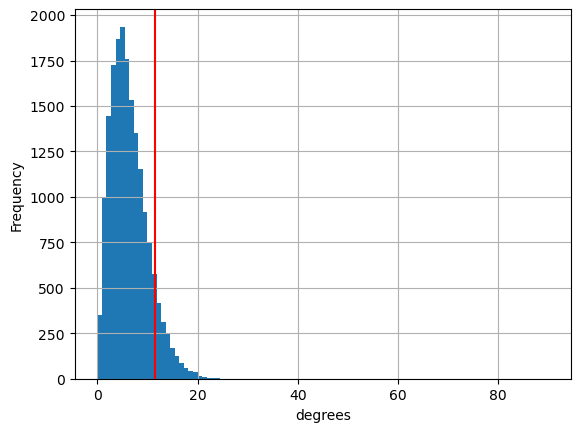

In [151]:
p = particle_infos[5].query("pdg == 15")
ax = (180/np.pi * np.arctan((p.px**2 + p.py**2)**0.5 / p.pz)).plot.hist(bins=np.linspace(0, 90, 100), xlabel="degrees")
ax.axvline(180/np.pi*0.2, c="r")
ax.grid()

In [154]:
180-180/np.pi*0.2

168.54084409738354

[Text(0.5, 0, 'Polar angle'), Text(0, 0.5, 'Count')]

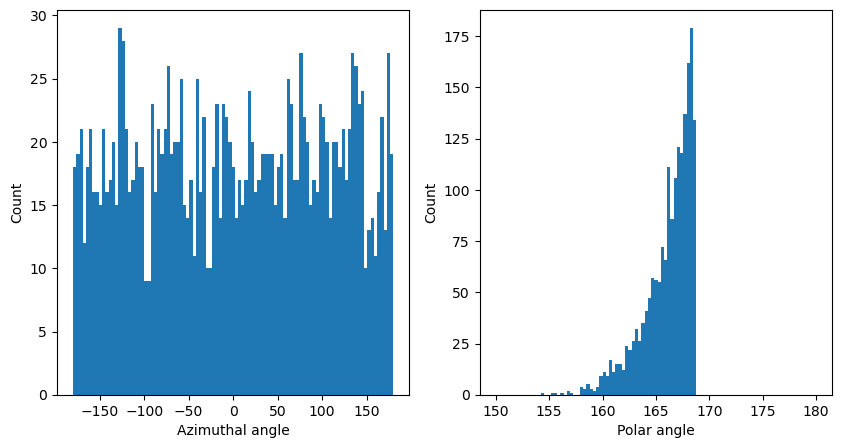

In [146]:
taus = large_angle_events.query("pdg == 15")
azimuth = 180/np.pi * np.arctan2(taus["polx"], taus["poly"])
polar = 180/np.pi * np.arccos(taus["polz"])
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
axs[0].hist(azimuth, bins=np.linspace(-180, 180, 100))
axs[0].set(xlabel="Azimuthal angle", ylabel="Count")
axs[1].hist(polar, bins=np.linspace(150, 180, 100))
axs[1].set(xlabel="Polar angle", ylabel="Count")

[Text(0.5, 0, 'Polar angle'), Text(0, 0.5, 'Count')]

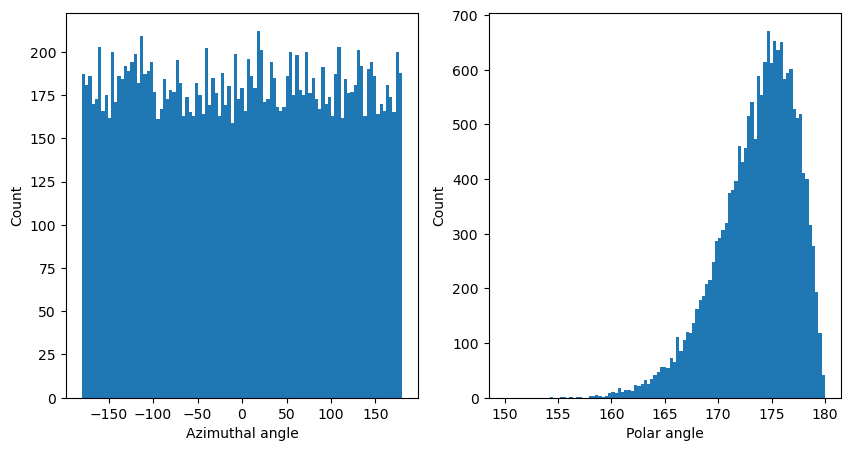

In [147]:
tau_all = particle_infos[5].query("pdg == 15")
azimuth = 180/np.pi * np.arctan2(tau_all["polx"], tau_all["poly"])
polar = 180/np.pi * np.arccos(tau_all["polz"])
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
axs[0].hist(azimuth, bins=np.linspace(-180, 180, 100))
axs[0].set(xlabel="Azimuthal angle", ylabel="Count")
axs[1].hist(polar, bins=np.linspace(150, 180, 100))
axs[1].set(xlabel="Polar angle", ylabel="Count")

[Text(0.5, 0, 'Polar angle'), Text(0, 0.5, 'Count')]

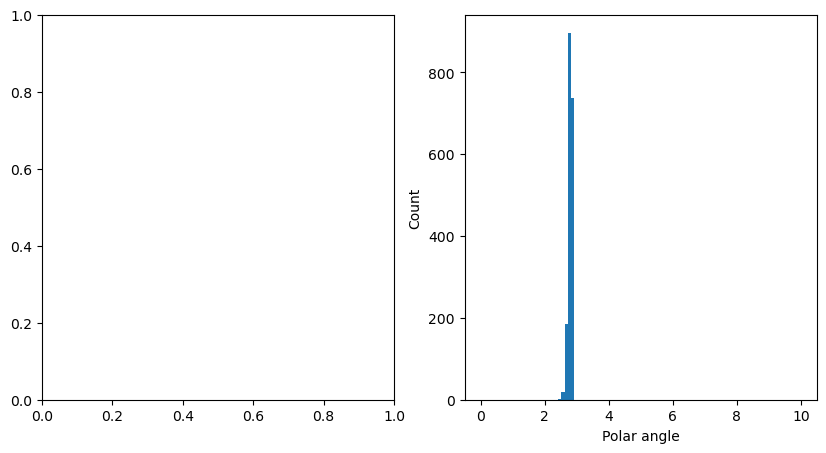

In [141]:
# Calculate the azimuth and polar angles of the polarization vector relative to the tau momentum vector
tau_momentum_direction = taus[["px", "py", "pz"]].values / np.linalg.norm(taus[["px", "py", "pz"]].values, axis=1)[:, np.newaxis]
angle_between = np.arccos(np.sum(tau_momentum_direction * taus[["polx", "poly", "polz"]].values, axis=1))
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
# axs[0].hist(azimuth, bins=np.linspace(-180, 180, 100))
# axs[0].set(xlabel="Azimuthal angle", ylabel="Count")
axs[1].hist(angle_between, bins=np.linspace(0, 10, 100))
axs[1].set(xlabel="Polar angle", ylabel="Count")

[Text(0.5, 0, 'Polar angle'), Text(0, 0.5, 'Count')]

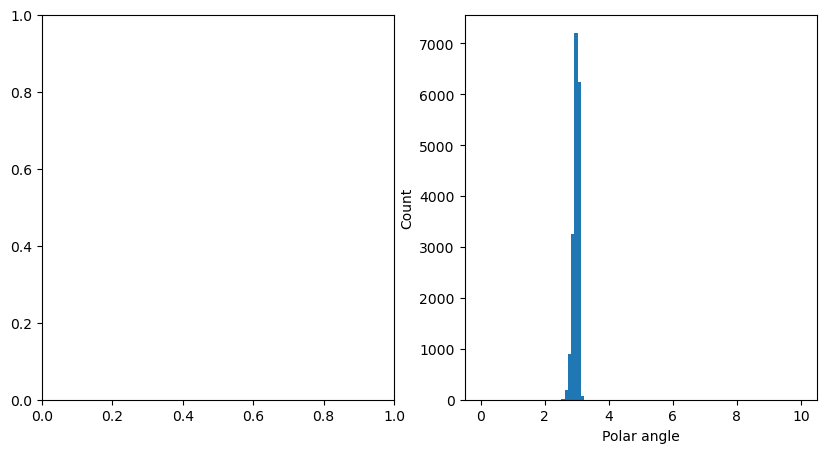

In [157]:
# Calculate the azimuth and polar angles of the polarization vector relative to the tau momentum vector
tau_momentum_direction = tau_all[["px", "py", "pz"]].values / np.linalg.norm(tau_all[["px", "py", "pz"]].values, axis=1)[:, np.newaxis]
angle_between = np.arccos(np.sum(tau_momentum_direction * tau_all[["polx", "poly", "polz"]].values, axis=1))
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
# axs[0].hist(azimuth, bins=np.linspace(-180, 180, 100))
# axs[0].set(xlabel="Azimuthal angle", ylabel="Count")
axs[1].hist(angle_between, bins=np.linspace(0, 10, 100))
axs[1].set(xlabel="Polar angle", ylabel="Count")

In [ ]:
# Calculate the azimuth and polar angles of the polarization vector relative to the tau momentum vector
tau_momentum_direction = tau_all[["px", "py", "pz"]].values / np.linalg.norm(tau_all[["px", "py", "pz"]].values, axis=1)[:, np.newaxis]
angle_between = np.arccos(np.sum(tau_momentum_direction * tau_all[["polx", "poly", "polz"]].values, axis=1))
fig, axs = plt.subplots(ncols=len(particle_infos), figsize=(3*len(particle_infos), 2), layout="constrained")
for e, ax in zip(axs, particle_infos):
    ax.hist(angle_between, bins=np.linspace(0, 10, 100))
    ax.set(xlabel="Polar angle", ylabel="Count")

[Text(0.5, 0, 'Polar angle'), Text(0, 0.5, 'Count')]

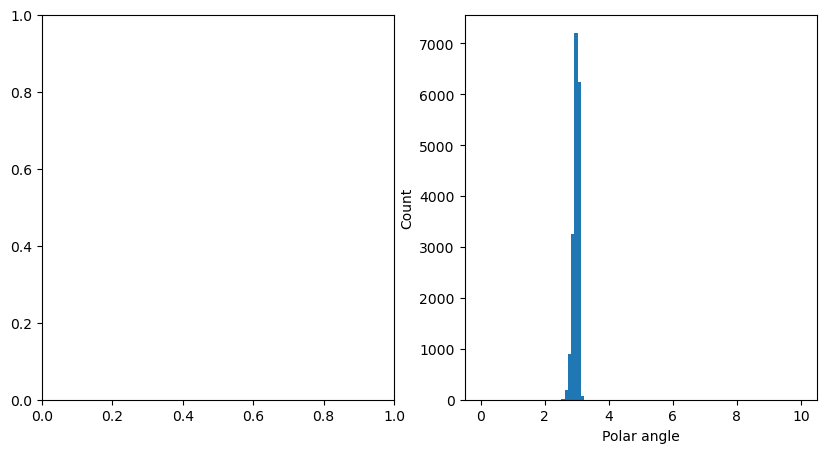

In [158]:
# Calculate the azimuth and polar angles of the polarization vector relative to the tau momentum vector
tau_momentum_direction = tau_all[["px", "py", "pz"]].values / np.linalg.norm(tau_all[["px", "py", "pz"]].values, axis=1)[:, np.newaxis]
angle_between = np.arccos(np.sum(tau_momentum_direction * tau_all[["polx", "poly", "polz"]].values, axis=1))
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
# axs[0].hist(azimuth, bins=np.linspace(-180, 180, 100))
# axs[0].set(xlabel="Azimuthal angle", ylabel="Count")
axs[1].hist(angle_between, bins=np.linspace(0, 10, 100))
axs[1].set(xlabel="Polar angle", ylabel="Count")

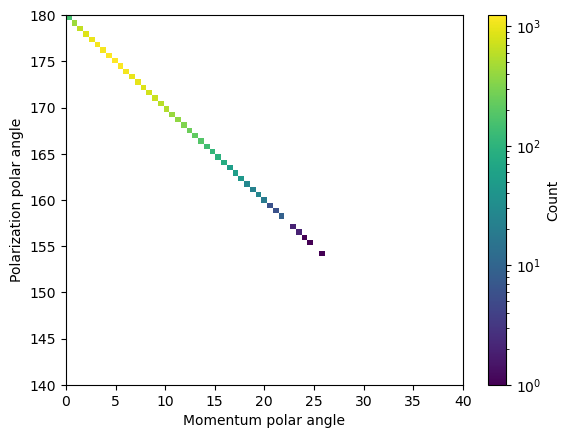

In [167]:
# Plot a 2D histogram with the tau polarization angle relative to the z axis, and the angle between the momentum vector and the z axis
fig, ax = plt.subplots()
*_, im = ax.hist2d(
    180/np.pi * np.arccos(tau_all["pz"] / np.linalg.norm(tau_all[["px", "py", "pz"]].values, axis=1)), 
    180/np.pi * np.arccos(tau_all["polz"]), 
    bins=(np.linspace(0, 40, 70), np.linspace(140, 180, 70)), norm=matplotlib.colors.LogNorm())
ax.set(xlabel="Momentum polar angle", ylabel="Polarization polar angle")
fig.colorbar(im, ax=ax, label="Count")

If the tau polarization angle were in the tau rest frame, there would (likely) have been a dependence between the tau momentum angle and the tau polarization angle. However, it would have been a more spread out dependence, since the tau polarization would not always have a specific angle.

For example, if the tau lepton were always fully polarized and the polarization vector is given in the tau rest frame, it would always have a value of 180 degrees, regardless of the tau momentum angle. If the polarization were given in the lab frame, it would be perfectly correlated with the tau momentum angle. 

In our case, the polarization angle almost perfectly correlates with the momentum angle, which is too good to be true for the tau rest frame case, meaning that the tau polarization vector is given in the lab frame.

## Analysis of old IceCube simulation events

In [ ]:
# Load the event info
event_info = pd.read_csv("genie_tau_decays_event_info.csv")
particle_info = pd.read_csv("genie_tau_decays_particles.csv")

### 4-momentum conservation

In [4]:
particle_info.head(13)

,event_num,pdg,E,px,py,pz
0,0,1000080160,14.895081,0.000000,0.000000,0.000000
1,0,-16,3.730323,0.185260,3.295873,1.737299
2,0,-15,3.251366,-0.023894,2.329548,1.409583
3,0,211,0.726490,-0.435732,-0.013640,0.564145
4,0,-16,2.524877,0.411767,2.343313,0.845184
5,1,1000080160,14.895081,0.000000,0.000000,0.000000
6,1,16,3.725654,-1.656092,-2.943322,1.573121
7,1,15,2.846514,-0.845274,-1.491209,1.416815
8,1,-211,0.395154,-0.365821,-0.047146,0.024889
9,1,-211,2.062102,-0.284192,-1.660413,1.181121


In [5]:
# Check if there are any events where two taus are produced
# There should not be any
assert not (particle_info[np.abs(particle_info['pdg']) == 15].groupby("event_num").count() > 1).any().any()
taus = particle_info[np.abs(particle_info["pdg"]) == 15]
assert (taus["event_num"] == np.arange(len(taus))).all()

In [6]:
taus

,event_num,pdg,E,px,py,pz
2,0,-15,3.251366,-0.023894,2.329548,1.409583
7,1,15,2.846514,-0.845274,-1.491209,1.416815
14,2,15,3.332381,-2.127187,-1.737024,-0.636785
19,3,15,3.509529,-0.032933,-0.487587,-2.986784
26,4,15,3.555693,-0.230564,-0.218090,-3.063518
...,...,...,...,...,...,...
447098,76638,-15,1003.199894,-392.660182,-607.363024,-695.222992
447104,76639,15,5031.544231,-4776.946270,-1257.860435,-956.559277
447110,76640,-15,75.985685,56.916040,-50.301859,-0.977036
447116,76641,15,1999.051556,-973.289879,1030.714386,1409.446214


In [7]:
np.unique(
    np.isclose(
        particle_info
            .drop("pdg", axis=1)
            .groupby("event_num")
            .nth[3:]
            .groupby("event_num")
            .sum(), 
        taus
            .set_index("event_num")
            .drop("pdg", axis=1)
        , rtol=0.01)
    .sum(axis=1)
    , return_counts=True
)

(array([0, 1, 2, 3, 4]), array([18011,   568,    61,   493, 57510]))

The number in the first array indicates how many of the 4-momentum components are within the given relative tolerance (rtol), while the number in the second array correspond to how many events have that number of components within the given relative tolerance.

We have a large collection of 4 (all components close in value) and 0 (none of the components are close in value), with a few events in between.

It is good that most events are 4, since that means that the 4-momentum is conserved.

The ones with 0 correspond to when the electron is not in the event, but the electron neutrino and tau neutrino are.

We now want to check if only the electron is missing, or if there are other events that look strange.

In [8]:
no_e_events = (
    particle_info
    .groupby("event_num")
    .filter(
        lambda df: set(np.abs(df.iloc[3:, 1]).tolist()) != {12, 16}
    )
)

In [9]:
no_e_eventnum = no_e_events["event_num"].unique()
tau_no_e = taus[taus["event_num"].isin(no_e_eventnum)]

In [10]:
tau_no_e

,event_num,pdg,E,px,py,pz
2,0,-15,3.251366,-0.023894,2.329548,1.409583
7,1,15,2.846514,-0.845274,-1.491209,1.416815
19,3,15,3.509529,-0.032933,-0.487587,-2.986784
26,4,15,3.555693,-0.230564,-0.218090,-3.063518
31,5,-15,3.758840,0.426761,3.153622,-0.918877
...,...,...,...,...,...,...
447098,76638,-15,1003.199894,-392.660182,-607.363024,-695.222992
447104,76639,15,5031.544231,-4776.946270,-1257.860435,-956.559277
447110,76640,-15,75.985685,56.916040,-50.301859,-0.977036
447116,76641,15,1999.051556,-973.289879,1030.714386,1409.446214


In [11]:
np.unique(np.isclose(no_e_events.drop("pdg", axis=1).groupby("event_num").nth[3:].groupby("event_num").sum(), 
           tau_no_e.set_index("event_num").drop("pdg", axis=1), rtol=0.1).sum(axis=1), return_counts=True)

(array([0, 1, 3, 4]), array([ 3592,     7,    48, 57926]))

There are still quite a lot of events that are not conserved. These will have to be investigated further.

In [12]:
n_correct_4m_components = np.isclose(
    no_e_events.drop("pdg", axis=1).groupby("event_num").nth[3:].groupby("event_num").sum(), 
    tau_no_e.set_index("event_num").drop("pdg", axis=1), 
    rtol=0.1
).sum(axis=1)

incorrect_event_num = tau_no_e[n_correct_4m_components == 0]["event_num"]

In [13]:
remaining_incorrect_events = no_e_events[no_e_events["event_num"].isin(incorrect_event_num)]
remaining_incorrect_events.groupby("event_num").nth[3:]

,event_num,pdg,E,px,py,pz
85437,14462,16,0.455603,0.227081,0.366221,-0.147955
86869,14705,-16,1.741897,1.335788,-0.653086,0.907389
91144,15425,211,7.821918,4.661051,5.020981,3.771907
91145,15425,211,4.364382,2.741274,2.651072,2.117920
91146,15425,-16,1.072879,0.628553,0.511290,0.703260
...,...,...,...,...,...,...
447095,76637,16,1653.625432,1446.779545,-506.715352,620.117384
447111,76640,211,4.219130,3.109955,-2.847443,-0.042789
447112,76640,211,9.417698,7.102254,-6.182930,-0.053989
447113,76640,-16,29.920689,22.462416,-19.763846,0.279041


There seem to be mostly events where the tau decays to a tau neutrino and nothing else. 

I would guess that this is because the tau neutrino decays to two photons and a tau neutrino, and then the photons are not included.
Since there are two particles that are unknown, it is not possible to determine their 4-momenta. They of course share half the missing energy each, but their directions are not known.

In [14]:
# Example:
particle_info.query("event_num == 14462")

,event_num,pdg,E,px,py,pz
85434,14462,1000080160,14.895081,0.000000,0.000000,0.000000
85435,14462,16,32.364764,6.430823,23.039574,-21.801387
85436,14462,15,30.744208,5.603906,22.255583,-20.379756
85437,14462,16,0.455603,0.227081,0.366221,-0.147955


We now want to check the other events:

In [15]:
remaining_incorrect_events2 = (
    remaining_incorrect_events
    .groupby("event_num")
    .filter(
        lambda df: not (
            (len(df.iloc[3:, 1]) == 1) 
            and (np.abs(df.iloc[3, 1]) == 16)
        )
    )
)

In [16]:
remaining_incorrect_events2.groupby("event_num").filter(lambda df: sorted(np.abs(df.iloc[3:, 1]).tolist()) != [16, 211, 211])

,event_num,pdg,E,px,py,pz
91904,15555,1000080160,14.895081,0.000000,0.000000,0.000000
91905,15555,16,47.054507,-7.615202,-19.700151,-42.048061
91906,15555,15,43.495663,-6.100936,-18.933855,-38.639401
91907,15555,111,9.426505,-0.809797,-3.802363,-8.586445
91908,15555,16,2.649729,-0.410884,-1.350791,-2.242232
...,...,...,...,...,...,...
447007,76619,2212,0.938270,0.000000,0.000000,0.000000
447008,76619,16,1168.397089,-1108.226844,182.089858,322.223995
447009,76619,15,559.871910,-530.591632,82.873574,158.296837
447010,76619,-211,21.691559,-20.524020,3.361495,6.161916


In [17]:
set(tuple(a.tolist()) for i, a in remaining_incorrect_events2.groupby("event_num").nth[3:].groupby("event_num")["pdg"])

{(-211, -211, 16),
 (-211, -16),
 (-211, 16),
 (-211, 211, 16),
 (-16, 211),
 (16, -211),
 (111, -211, 16),
 (111, -16),
 (111, 16),
 (111, 111, -16),
 (111, 111, 16),
 (111, 211, -16),
 (211, -211, -16),
 (211, -16),
 (211, 16),
 (211, 211, -16)}

Decay modes that seem to be strange:

16

12, 16

211, 16

111, 16

211, 211, 16

111, 211, 16

111, 111, 16

111, 16: 15555
16: 14462
12, 16: 2



In [18]:
first_decay_product = particle_info.groupby("event_num").nth[3]
first_decay_product[first_decay_product["pdg"].abs() == 16]

,event_num,pdg,E,px,py,pz
85437,14462,16,0.455603,0.227081,0.366221,-0.147955
86869,14705,-16,1.741897,1.335788,-0.653086,0.907389
91563,15496,-16,1.900433,-1.141250,-1.146876,0.996930
93502,15822,-16,5.777562,-0.828564,5.506056,1.541767
95836,16219,-16,1.818010,-1.317725,1.229358,-0.239665
...,...,...,...,...,...,...
447066,76631,16,344.234924,-227.653441,208.804614,151.895446
447075,76633,16,373.356422,-254.399312,207.444290,-177.884442
447079,76634,16,504.537618,304.261142,-401.126038,32.882629
447095,76637,16,1653.625432,1446.779545,-506.715352,620.117384


### Charge conservation

In [19]:
particle_info.iloc[2:3, :]

,event_num,pdg,E,px,py,pz
2,0,-15,3.251366,-0.023894,2.329548,1.409583


In [20]:
# Check that for every event with a tau there is a tau neutrino, and vice versa for anti-tau
for event_num, df in particle_info.groupby("event_num"):
    second_neutrino_pdg = df.iloc[3:, 1][df.iloc[3:, 1].abs() == 16].iloc[0]
    print(second_neutrino_pdg)
    assert df.iloc[2, 1] * second_neutrino_pdg > 0
    break

-16


## Branching ratios
Check branching ratios of the various decay modes to see if it matches what we expect from e.g., PDG

In [21]:
c = Counter(tuple(sorted(a.tolist())) for i, a in particle_info.groupby("event_num").nth[2:].groupby("event_num")["pdg"])

In [22]:
n_taus = (particle_info["pdg"] == 15).sum()
n_anti_taus = (particle_info["pdg"] == -15).sum()
n_taus, n_anti_taus

(53172, 23471)

In [23]:
br = {}
for pdgs, n in c.items():
    if 15 in pdgs:
        br[(15, *pdgs[:pdgs.index(15)], *pdgs[pdgs.index(15)+1:])] = n / n_taus
    elif -15 in pdgs:
        br[(-15, *pdgs[:pdgs.index(-15)], *pdgs[pdgs.index(-15)+1:])] = n / n_anti_taus
    else:
        raise ValueError("No tau in the event")
br

{(-15, -16, 211): 0.11482254697286012,
 (15, -211, -211, 16, 211): 0.09958248702324532,
 (15, -12, 16): 0.19335364477544573,
 (15, -211, 16, 111, 111): 0.09832242533664334,
 (15, -211, 16): 0.11758068156172422,
 (-15, -16, 111, 111, 211): 0.09582037407865025,
 (-15, -16, 12): 0.20403902688424014,
 (15, -211, 16, 111): 0.26811103588354773,
 (15, -14, 13, 16): 0.18966749416986384,
 (-15, -16, 111, 211): 0.2654339397554429,
 (-15, -16, -13, 14): 0.1789016232797921,
 (-15, -211, -16, 211, 211): 0.10008095096076008,
 (15, -12, 11, 16): 0.0008651169788610547,
 (-15, -16, -11, 12): 0.0006390865323164757,
 (15, 16): 0.018712856390581508,
 (-15, -16): 0.024583528609773763,
 (-15, -16, 211, 211): 0.0017042307528439351,
 (15, 16, 111): 0.008369066425938465,
 (-15, -211, -16, 211): 0.003025009586297985,
 (-15, -16, 111, 111): 0.0012781730646329514,
 (15, -211, 16, 211): 0.0025765440457383585,
 (-15, -16, 111): 0.008819394145967364,
 (15, 16, 111, 111): 0.001184834123222749,
 (15, -211, -211, 16): 

In [24]:
pdg2name = {15: "tau-", 16: "nu_tau", 211: "pi+", -15: "tau+", -16: "nu_tau_bar", -211: "pi-", 111: "pi0", 13: "mu-", -13: "mu+", 14: "nu_mu", -14: "nu_mu_bar", 11: "e-", -11: "e+", 12: "nu_e", -12: "nu_e_bar"}

for pdgs, n in br.items():
    for pdg in pdgs:
        print(pdg2name[pdg], end=" ")
    print(":", n*100)

tau+ nu_tau_bar pi+ : 11.482254697286013
tau- pi- pi- nu_tau pi+ : 9.958248702324532
tau- nu_e_bar nu_tau : 19.335364477544573
tau- pi- nu_tau pi0 pi0 : 9.832242533664335
tau- pi- nu_tau : 11.758068156172422
tau+ nu_tau_bar pi0 pi0 pi+ : 9.582037407865025
tau+ nu_tau_bar nu_e : 20.403902688424015
tau- pi- nu_tau pi0 : 26.811103588354772
tau- nu_mu_bar mu- nu_tau : 18.966749416986385
tau+ nu_tau_bar pi0 pi+ : 26.543393975544287
tau+ nu_tau_bar mu+ nu_mu : 17.89016232797921
tau+ pi- nu_tau_bar pi+ pi+ : 10.008095096076008
tau- nu_e_bar e- nu_tau : 0.08651169788610547
tau+ nu_tau_bar e+ nu_e : 0.06390865323164757
tau- nu_tau : 1.8712856390581507
tau+ nu_tau_bar : 2.458352860977376
tau+ nu_tau_bar pi+ pi+ : 0.17042307528439352
tau- nu_tau pi0 : 0.8369066425938465
tau+ pi- nu_tau_bar pi+ : 0.3025009586297985
tau+ nu_tau_bar pi0 pi0 : 0.12781730646329514
tau- pi- nu_tau pi+ : 0.25765440457383587
tau+ nu_tau_bar pi0 : 0.8819394145967364
tau- nu_tau pi0 pi0 : 0.11848341232227488
tau- pi- pi- n

```
tau | decay products | branching ratio              | PDG
------------------------------------------------------------
tau+ nu_tau_bar pi+ : 11.482254697286013            10.8164
tau- pi- pi- nu_tau pi+ : 9.958248702324532         8.9868
tau- nu_e_bar nu_tau : 19.335364477544573           17.8175 x
tau- pi- nu_tau pi0 pi0 : 9.832242533664335         9.2595
tau- pi- nu_tau : 11.758068156172422                10.8164
tau+ nu_tau_bar pi0 pi0 pi+ : 9.582037407865025     9.2595 
tau+ nu_tau_bar nu_e : 20.403902688424015           17.8175 x
tau- pi- nu_tau pi0 : 26.811103588354772            25.4941
tau- nu_mu_bar mu- nu_tau : 18.966749416986385      17.3937
tau+ nu_tau_bar pi0 pi+ : 26.543393975544287        25.4941
tau+ nu_tau_bar mu+ nu_mu : 17.89016232797921       17.3937
tau+ pi- nu_tau_bar pi+ pi+ : 10.008095096076008    8.9868
tau- nu_e_bar e- nu_tau : 0.08651169788610547       17.8175 (same as above??)
tau+ nu_tau_bar e+ nu_e : 0.06390865323164757       17.8175 (same as above??)
tau- nu_tau : 1.8712856390581507                    0.6964 x
tau+ nu_tau_bar : 2.458352860977376                 0.6964 x
tau+ nu_tau_bar pi+ pi+ : 0.17042307528439352       ?
tau- nu_tau pi0 : 0.8369066425938465                0.4328 x
tau+ pi- nu_tau_bar pi+ : 0.3025009586297985        0.2927 x
tau+ nu_tau_bar pi0 pi0 : 0.12781730646329514       0.0647 x
tau- pi- nu_tau pi+ : 0.25765440457383587           0.2927 x
tau+ nu_tau_bar pi0 : 0.8819394145967364            0.4328 x
tau- nu_tau pi0 pi0 : 0.11848341232227488           0.0647 x
tau- pi- pi- nu_tau : 0.1260061686601971            ?
tau- nu_tau pi+ : 0.04137515985857218               ?
tau+ pi- nu_tau_bar : 0.08521153764219676           ?
```

In [25]:
pdg_brs = [
    10.8164,
    8.9868,
    17.8175,
    9.2595,
    10.8164,
    9.2595 ,
    17.8175,
    25.4941,
    17.3937,
    25.4941,
    17.3937,
    8.9868,
]

print("Tau, decay products, branching ratio (%), Poisson error (%), PDG branching ratio (%), difference (sigma)")
for i, ((pdgs, n_br), pdg_br) in enumerate(zip(c.items(), pdg_brs)):
    if i >= 12:
        break
    
    n = n_taus if 15 in pdgs else n_anti_taus
    print(pdgs, n_br / n * 100, np.sqrt(n_br)/n * 100, pdg_br, np.abs((n_br / n * 100 - pdg_br) / (np.sqrt(n_br)/n * 100)))

Tau, decay products, branching ratio (%), Poisson error (%), PDG branching ratio (%), difference (sigma)
(-16, -15, 211) 11.482254697286013 0.22118098679080414 10.8164 3.0104517885879014
(-211, -211, 15, 16, 211) 9.958248702324532 0.13685163365851494 8.9868 7.098553932856817
(-12, 15, 16) 19.335364477544573 0.19069297028829124 17.8175 7.959729586517288
(-211, 15, 16, 111, 111) 9.832242533664335 0.13598305485989032 9.2595 4.211866943675144
(-211, 15, 16) 11.758068156172422 0.14870531408087562 10.8164 6.332444553126609
(-16, -15, 111, 111, 211) 9.582037407865025 0.20205199099108478 9.2595 1.5963089810842659
(-16, -15, 12) 20.403902688424015 0.2948430024591361 17.8175 8.77213522739947
(-211, 15, 16, 111) 26.811103588354772 0.2245514414594042 25.4941 5.86504179084893
(-14, 13, 15, 16) 18.966749416986385 0.18886650999212168 17.3937 8.32889545664821
(-16, -15, 111, 211) 26.543393975544287 0.3362888204281218 25.4941 3.1202166465375054
(-16, -15, -13, 14) 17.89016232797921 0.276084066964721 17

The branching ratios match relatively well but compared to the PDG official branching ratios, most of them differ by > 4 sigma, which cannot be explained purely by low statstics. This either means that:
- the labeling is not correct for any of the processes
- the branching ratios in Geant4 differ quite significantly from the PDG branching ratios
- The PDG branching ratios differ because they take some kind of polarization into account
- The PDG branching ratios differ because the branching ratios must be weighted (see PDF). However, most branching ratios seem to have a coefficient of 1 anyway, so I do not think this has a large effect. Though I can be wrong.

In any case, the branching ratios do not differ from the PDG branching ratios by a factor of 2 or something like that (except for the questionable ones), so I can probably use them for comparisons with Tauola for now, until I have better samples.

### Nucleus

In [26]:
nucleus = particle_info.groupby("event_num").first()

In [27]:
nucleus.pdg.value_counts()

pdg
1000080160    69412
2212           7231
Name: count, dtype: int64

In [4]:
69412 / (69412 + 7231), 7231 / (69412 + 7231)

(0.9056534843364691, 0.09434651566353092)

In [28]:
nucleus.E.value_counts()

E
14.895081    69412
0.938270      7231
Name: count, dtype: int64

We mostly have interactions with the oxygen nucleus, but we also have a few with a proton, i.e., hydrogen nucleus. This looks reasonable.

The energy is also what we expect.

### Tau energy

In [29]:
taus = particle_info[particle_info["pdg"] == 15]
anti_taus = particle_info[particle_info["pdg"] == -15]

In [30]:
taus["E"].min(), taus["E"].max()

(2.2156010004372018, 9188.968005893275)

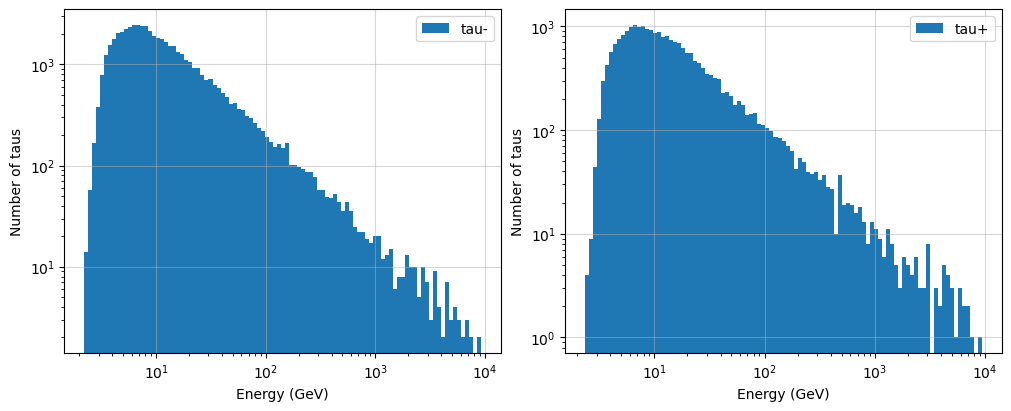

In [31]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 4), ncols=2, layout="constrained")

ax1.hist(taus["E"], bins=np.geomspace(taus["E"].min(), taus["E"].max(), 100), label="tau-")
ax2.hist(anti_taus["E"], bins=np.geomspace(anti_taus["E"].min(), anti_taus["E"].max(), 100), label="tau+")

for ax in (ax1, ax2):
    ax.set(xscale="log", yscale="log", xlabel="Energy (GeV)", ylabel="Number of taus")
    ax.grid(True, alpha=0.5)
    ax.legend()

In [32]:
nutaus = particle_info.groupby("event_num").nth(1)
anti_nutaus = nutaus.query("pdg == -16")
nutaus = nutaus.query("pdg == 16")

In [33]:
particle_info.groupby("event_num").nth(1)["pdg"].value_counts()

pdg
 16    53172
-16    23471
Name: count, dtype: int64

In [34]:
# Check that tau*nutau PDG is always greater than 0, i.e., they have the same sign
assert ((nutaus["pdg"].values * taus["pdg"].values) > 0).all()
assert ((anti_nutaus["pdg"].values * anti_taus["pdg"].values) > 0).all()

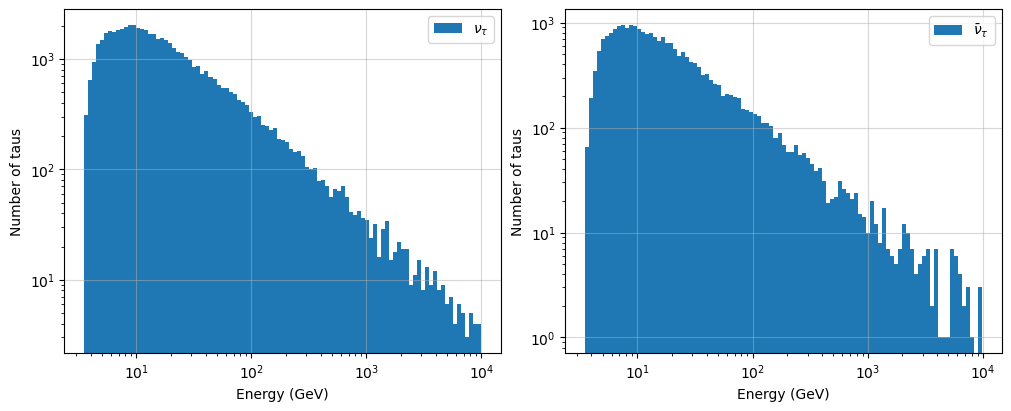

In [35]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 4), ncols=2, layout="constrained")

ax1.hist(nutaus["E"], bins=np.geomspace(nutaus["E"].min(), nutaus["E"].max(), 100), label=r"$\nu_\tau$")
ax2.hist(anti_nutaus["E"], bins=np.geomspace(anti_nutaus["E"].min(), anti_nutaus["E"].max(), 100), label=r"$\bar\nu_\tau$")

for ax in (ax1, ax2):
    ax.set(xscale="log", yscale="log", xlabel="Energy (GeV)", ylabel="Number of taus")
    ax.grid(True, alpha=0.5)
    ax.legend()

$\nu_\tau$ and $\tau$ energy distributions are similar. We are mostly interested in the low-energy events, where the energy is < 50 GeV.

## Analyze event information
Just for sanity checks

In [36]:
event_info.sum(axis=0)

event_num    2.937036e+09
cc           7.664300e+04
dis          4.067000e+04
qel          1.594000e+04
res          2.001700e+04
xsec         8.392645e+06
dtype: float64

There seems to be the same order of magnitude of DIS, QEL and RES events, with a majority of DIS events.

In [37]:
event_info["cc"].all()

True

All events are CC, which is good since those are the only ones we are interested in.

# Only tau decays
The file analyzed below are only simulations of tau particles decaying in Geant4, i.e., no neutrinos interacting with ice in GENIE first.
This is mainly (or only) useful for checking decay branching ratios.

In [2]:
tau_decays = pd.read_csv("tau_decays_159007_particles.csv")

In [7]:
c = Counter(tuple(sorted(a.tolist())) for i, a in tau_decays.groupby("event_num")["pdg"])

In [9]:
n_taus = (tau_decays["pdg"] == 15).sum()
n_anti_taus = (tau_decays["pdg"] == -15).sum()
n_taus, n_anti_taus

(38916, 0)

In [10]:
br = {}
for pdgs, n in c.items():
    if 15 in pdgs:
        br[(15, *pdgs[:pdgs.index(15)], *pdgs[pdgs.index(15)+1:])] = n / n_taus
    elif -15 in pdgs:
        br[(-15, *pdgs[:pdgs.index(-15)], *pdgs[pdgs.index(-15)+1:])] = n / n_anti_taus
    else:
        raise ValueError("No tau in the event")
br

{(15, -211, 16, 111): 0.2877993627299825,
 (15, -211, 16): 0.11039161270428616,
 (15, -211, -211, 16, 211): 0.0953078425326344,
 (15, -14, 13, 16): 0.19727104532839962,
 (15, -12, 11, 16): 0.2049799568300956,
 (15, -211, 16, 111, 111): 0.10425017987460171}

Source: https://geant4-userdoc.web.cern.ch/UsersGuides/ForApplicationDeveloper/html/TrackingAndPhysics/AllResources/TrackingAndPhysics/particleList.src/leptons/tau-.html and https://github.com/Geant4/geant4/blob/master/source/particles/leptons/src/G4TauMinus.cc

| Decay mode | Branching ratio in code | Branching ratio in simulation | 
| --- | -- |-- |
13, -14 | 0.1736         | 0.19727104532839962
11, -12 | 0.1784         | 0.2049799568300956
-211 | 0.1106            | 0.11039161270428616
-211, 111 | 0.2541       | 0.2877993627299825
-211, 111, 111| 0.0917  | 0.10425017987460171
-211, -211, 211 | 0.0946 |  0.0953078425326344
Total | 0.903 | 1.0

In [2]:
sum([2.5410000e-01,1.7840000e-01,1.7360000e-01,1.1060000e-01,9.4600000e-02,9.1700000e-02])

0.903

In [1]:
0.1736 + 0.1784 + 0.1106 + 0.2541 + 0.0917 + 0.0946

0.903

In [11]:
pdg2name = {15: "tau-", 16: "nu_tau", 211: "pi+", -15: "tau+", -16: "nu_tau_bar", -211: "pi-", 111: "pi0", 13: "mu-", -13: "mu+", 14: "nu_mu", -14: "nu_mu_bar", 11: "e-", -11: "e+", 12: "nu_e", -12: "nu_e_bar"}

for pdgs, n in br.items():
    for pdg in pdgs:
        print(pdg2name[pdg], end=" ")
    print(":", n*100)

tau- pi- nu_tau pi0 : 28.779936272998253
tau- pi- nu_tau : 11.039161270428616
tau- pi- pi- nu_tau pi+ : 9.53078425326344
tau- nu_mu_bar mu- nu_tau : 19.727104532839963
tau- nu_e_bar e- nu_tau : 20.49799568300956
tau- pi- nu_tau pi0 pi0 : 10.425017987460171


Check 4-momentum conservation:

In [14]:
# Check if there are any events where two taus are produced
# There should not be any
assert not (tau_decays[np.abs(tau_decays['pdg']) == 15].groupby("event_num").count() > 1).any().any()
taus = tau_decays[np.abs(tau_decays["pdg"]) == 15]
assert (taus["event_num"] == np.arange(len(taus))).all()

In [15]:
taus

,event_num,pdg,E,px,py,pz
0,0,15,2.77682,-0.0,-0.0,2.133926
4,1,15,2.77682,-0.0,-0.0,2.133926
7,2,15,2.77682,-0.0,-0.0,2.133926
11,3,15,2.77682,-0.0,-0.0,2.133926
16,4,15,2.77682,-0.0,-0.0,2.133926
...,...,...,...,...,...,...
159113,38911,15,101.77682,-0.0,-0.0,101.761309
159117,38912,15,101.77682,-0.0,-0.0,101.761309
159122,38913,15,101.77682,-0.0,-0.0,101.761309
159126,38914,15,101.77682,-0.0,-0.0,101.761309


In [23]:
np.unique(
    np.isclose(
        tau_decays
            .drop("pdg", axis=1)
            .groupby("event_num")
            .nth[1:]
            .groupby("event_num")
            .sum(), 
        taus
            .set_index("event_num")
            .drop("pdg", axis=1)
        , atol=0.01)
    .sum(axis=1)
    , return_counts=True
)

(array([2, 4]), array([   40, 38876]))